# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [3]:
# your code here
bikes_df = pd.read_csv('data/BSS_hour_raw.csv', delimiter=',')
bikes_df.shape

(17379, 13)

In [4]:
# your code here
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

In [5]:
# your code here
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


**Answer:**

*We observe that maximum for 'casual' and 'registered' are way higher considering their mean and standard deviation. That means we have some outliers there. Also, 'temp', 'hum', 'atemp' and 'windspeed are all between $0$ and $1$, which means that they are normalized.*

*We can also see that season, workingday, weekday and holiday are all integers but should be categorical.*

#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [6]:
# your code here
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'])

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that hour (this is the response variable for later).

In [7]:
# your code here
bikes_df['year'] = bikes_df['dteday'].dt.year - 2011
bikes_df['month'] = bikes_df['dteday'].dt.month
bikes_df['counts'] = bikes_df['casual'] + bikes_df['registered']

In [8]:
# your code here
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


<div class='exercise'> <b> Question 2: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 



### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C4FBB38>,
      dtype=object)

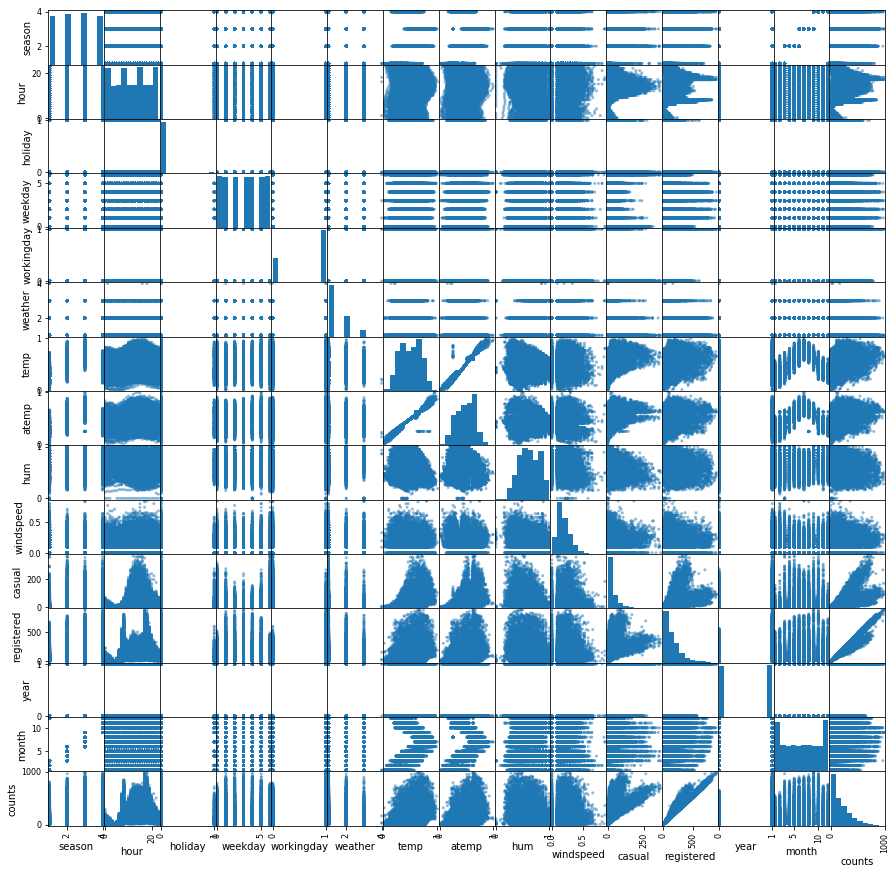

In [9]:
# your code here
pd.plotting.scatter_matrix(bikes_df, figsize = (15,15), grid = True)

**Answer:**

*We could see that 'temp' and 'atemp' are strongly correlated to each other. 'hour' and 'temp'/'atemp' also have a polynomial relationhip. 'counts' is also strongly correlated to 'casual' and 'registered' for the obvious reason that it calculated using the later two. This points out that there is multi-collinearity in the predictor variables and that we should take out the correlated predictors before doing the analysis.*

*We see linear relation between 'counts' and 'temp' and a polynomial relationship between 'counts' and 'hour'. 'weather' shows a strong relationship with 'counts' as well, the counts seem to go down with increase in weather severity. We can also see the 'temp' and 'atemp' peaking at the middle of the year which might bring out the months of May-July as a significant predictor of counts, since 'temp' is also has a relationship with 'counts'.Windspeed also shows somewhat negative correlation.*

#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

Text(0.5,1,'Average Number of Riders for Each Hour')

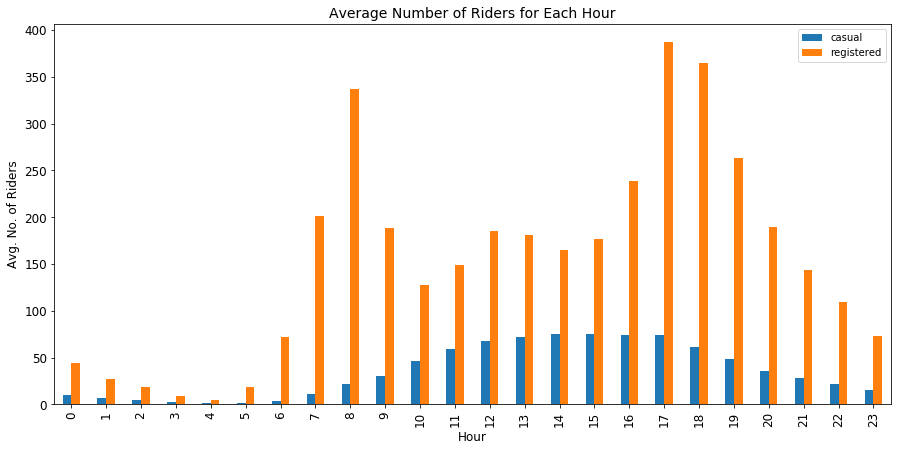

In [10]:
# your code here
bikes_gb_hr = bikes_df.groupby(by = 'hour')
df_bar = bikes_gb_hr[['casual', 'registered']].mean()

df_bar.index

fig_hr, ax_hr = plt.subplots(1, 1, figsize=(15,7))
df_bar.plot.bar(ax = ax_hr)
ax_hr.set_xlabel('Hour', fontsize=12)
ax_hr.set_ylabel('Avg. No. of Riders', fontsize=12)
ax_hr.tick_params(labelsize=12)
ax_hr.set_title('Average Number of Riders for Each Hour', fontsize=14)

**Answer:**

*We can see the registered riders spiking at 8 AM and between 5 to 6 PM, which are the peak office hours, which could potentially mean that a lot of the registered riders use the bikes to go to work. The casual riders show a smoother curve from 7 AM to 11 PM with peak being between 2 PM to 5 PM.*


#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

In [11]:
# your code here
bikes_gb_wr = bikes_df.groupby(by = ['weather'])
bikes_gb_wr1 = bikes_df[bikes_df.weather == 1].groupby(by = ['weather', 'hour'])
bikes_gb_wr2 = bikes_df[bikes_df.weather == 2].groupby(by = ['weather', 'hour'])
bikes_gb_wr3 = bikes_df[bikes_df.weather == 3].groupby(by = ['weather', 'hour'])
bikes_gb_wr4 = bikes_df[bikes_df.weather == 4].groupby(by = ['weather', 'hour'])

df_bar_wr = bikes_gb_wr[['casual', 'registered']].mean()
casual1 = bikes_gb_wr1.casual.mean()
casual2 = bikes_gb_wr2.casual.mean()
casual3 = bikes_gb_wr3.casual.mean()
casual4 = bikes_gb_wr4.casual.mean()

registered1 = bikes_gb_wr1.registered.mean()
registered2 = bikes_gb_wr2.registered.mean()
registered3 = bikes_gb_wr3.registered.mean()
registered4 = bikes_gb_wr4.registered.mean()

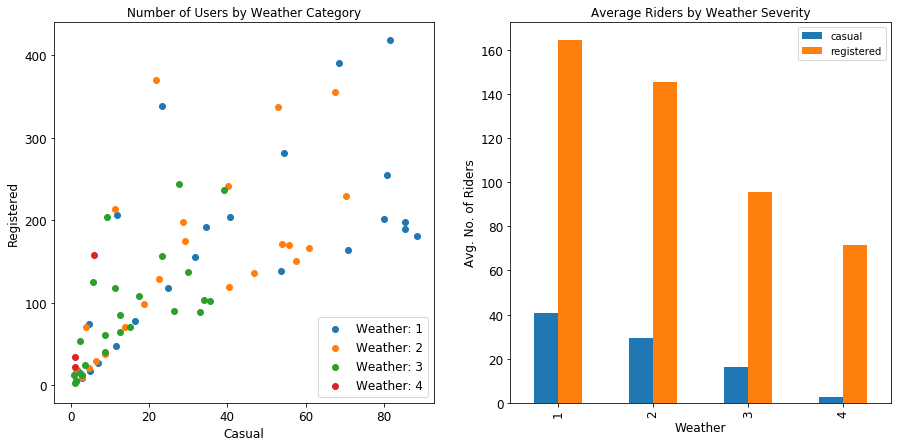

In [12]:
# your code here
fig_wr, ax_wr = plt.subplots(1, 2, figsize=(15,7))
ax_wr[0].scatter(casual1, registered1, label = 'Weather: 1')
ax_wr[0].scatter(casual2, registered2, label = 'Weather: 2')
ax_wr[0].scatter(casual3, registered3, label = 'Weather: 3')
ax_wr[0].scatter(casual4, registered4, label = 'Weather: 4')
ax_wr[0].set_xlabel('Casual', fontsize=12)
ax_wr[0].set_ylabel('Registered', fontsize=12)
ax_wr[0].tick_params(labelsize=12)
ax_wr[0].set_title('Number of Users by Weather Category', fontsize=12)
ax_wr[0].legend(loc = 'best', fontsize=12)

df_bar_wr.plot.bar(ax = ax_wr[1], title = 'Average Riders by Weather Severity')
ax_wr[1].set_xlabel('Weather', fontsize=12)
ax_wr[1].set_ylabel('Avg. No. of Riders', fontsize=12)
ax_wr[1].tick_params(labelsize=12)



**Answer:**

*From the right plot, we can clearly see that as weather severity increses, the average number of riders go down for both the groups - casual and registered users.*

*The left plot shows somewhat of a linear relationship between registered and casual riders. Observe how the weather category 1 and 2 affects casual users more than the registered - we can see this by the cluster where $casual > 40$ and $100 < registered < 250$. Also notice how the weather 3 and 4 are both clustered very close to 0 for both users.*

#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [13]:
# your code here
bikes_gb_day = bikes_df.groupby('dteday')
bikes_by_day_agg = bikes_gb_day.agg({'weekday': 'max', 'weather': 'max', 'season': 'max', 'temp': 'mean', 'atemp': 'mean', 
                                 'windspeed': 'mean', 'hum': 'mean', 'casual': 'sum', 'registered': 'sum', 'counts': 'sum'
                                })
bikes_by_day = pd.DataFrame(bikes_by_day_agg)
bikes_by_day.describe()

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.997264,2.207934,2.496580,0.495385,0.474354,0.190486,0.627894,848.176471,3656.172367,4504.348837
std,2.004787,0.766056,1.110807,0.183051,0.162961,0.077498,0.142429,686.622488,1560.256377,1937.211452
min,0.000000,1.000000,1.000000,0.059130,0.079070,0.022392,0.000000,2.000000,20.000000,22.000000
25%,1.000000,2.000000,2.000000,0.337083,0.337842,0.134950,0.520000,315.500000,2497.000000,3152.000000
50%,3.000000,2.000000,3.000000,0.498333,0.486733,0.180975,0.626667,713.000000,3662.000000,4548.000000
75%,5.000000,3.000000,3.000000,0.655417,0.608602,0.233215,0.730208,1096.000000,4776.500000,5956.000000
max,6.000000,4.000000,4.000000,0.861667,0.840896,0.507463,0.972500,3410.000000,6946.000000,8714.000000


Text(0.5,1,'Violin Plots for Rider Type on Each Weekday')

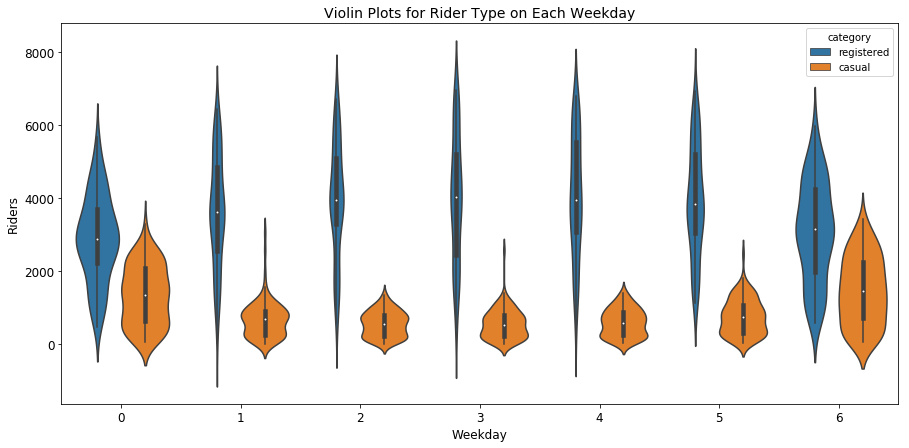

In [14]:
fig_h, ax_h = plt.subplots(1, 1, figsize=(15,7))
temp_df = bikes_by_day.copy()
del temp_df['registered']
del temp_df['casual']
temp_df = pd.concat([temp_df]*2)
temp_df['modified'] = bikes_by_day.registered.append(bikes_by_day.casual)
temp_df['category'] = "casual"
temp_df.loc[:bikes_by_day.shape[0],'category'] = str('registered')

sns.violinplot(x="weekday", y="modified", data=temp_df, hue='category')
ax_h.tick_params(labelsize=12)
ax_h.set_xlabel('Weekday', fontsize=12)
ax_h.set_ylabel('Riders', fontsize=12)
ax_h.set_title('Violin Plots for Rider Type on Each Weekday', fontsize=14)

**Answer:**

*Notice that the distribution for casual riders is narrower during the weekdays as compared to the weekend, whereas for the registered riders it is narrower during the weekends as compared to the weekdays.*

#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

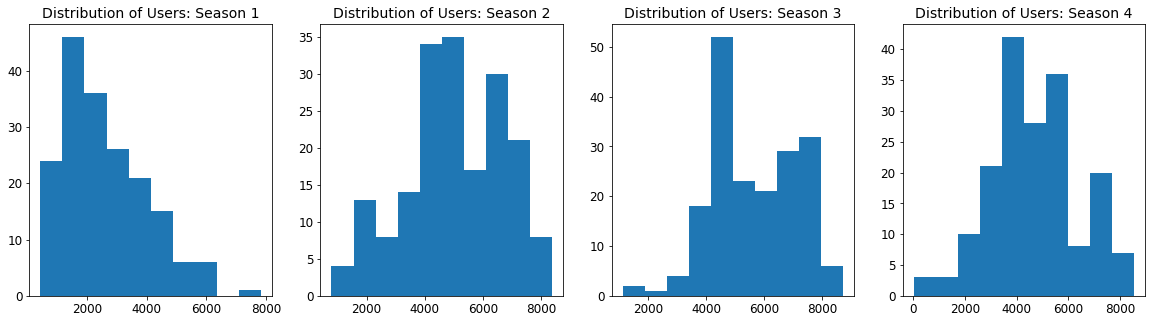

In [15]:
# your code here 
fig_ct1, ax_ct1 = plt.subplots(1, 4, figsize=(20,5))

for i in bikes_by_day.season.unique():
    ax_ct1[i-1].hist(bikes_by_day[bikes_by_day.season == i].counts)
    ax_ct1[i-1].tick_params(labelsize=12)
    ax_ct1[i-1].set_title('Distribution of Users: Season %s'%str(i), fontsize=14)

Text(0.5,1,'Total Users by Season')

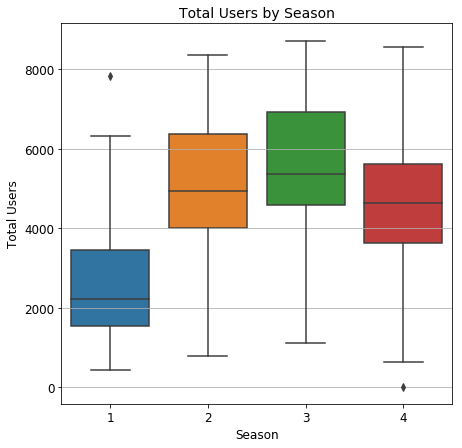

In [16]:
# your code here
fig_ct, ax_ct = plt.subplots(1, 1, figsize=(7,7))
sns.boxplot(x = 'season', y = 'counts', data = bikes_by_day)
ax_ct.set_xlabel('Season', fontsize=12)
ax_ct.set_ylabel('Total Users', fontsize=12)
ax_ct.tick_params(labelsize=12)
ax_ct.grid(True, axis = 'y')
ax_ct.set_title('Total Users by Season', fontsize=14)

In [17]:
# your code here
for i in range (1, 5):
    q75, q25 = np.percentile(bikes_by_day[(bikes_by_day.season == i)]['counts'], [75, 25])
    iqr = q75 - q25

    maxi = q75 + (iqr*1.5)
    mini = q25 - (iqr*1.5)
    if bikes_by_day[(bikes_by_day.season == i) & ((bikes_by_day.counts > maxi) | (bikes_by_day.counts < mini))].shape[0] > 0:
        display(bikes_by_day[(bikes_by_day.season == i) & ((bikes_by_day.counts > maxi) | (bikes_by_day.counts < mini))])

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2012-03-17,6,2,1,0.514167,0.505046,0.110704,0.755833,3155,4681,7836


,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2012-10-29,1,3,4,0.44,0.4394,0.3582,0.88,2,20,22


**Answer**

*2012-10-29 was the day when Hurricane Sandy occurred, so there is significant less total riders that day. 2012-03-17 can be a chance because of very conducive weather conditions (temp = 0.5, weather = 2) occuring on a Saturday right after a winter.*


<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [18]:
# your code here
bikes_df_hot = pd.get_dummies(bikes_df, columns = ['season', 'month', 'weekday', 'weather'], drop_first = True)

In [19]:
#your code here
bikes_df_hot.columns

Index(['dteday', 'hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'year', 'counts', 'season_2',
       'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [20]:
#your code here
bikes_df_hot.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0


####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

In [21]:
# your code here
bikes_train, bikes_test = train_test_split(bikes_df_hot, test_size = 0.2, random_state = 42,
                                             stratify=bikes_df_hot[['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                                                                    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 
                                                                    'month_12']])

In [22]:
# your code here
bikes_train.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
10701,2012-03-27,0,0,1,0.32,0.2879,0.26,0.5224,1,9,...,0,0,1,0,0,0,0,0,0,0
11051,2012-04-10,15,0,1,0.56,0.5303,0.21,0.2985,46,157,...,0,0,1,0,0,0,0,0,0,0
12703,2012-06-18,12,0,1,0.56,0.5303,0.78,0.1343,29,139,...,0,1,0,0,0,0,0,0,1,0
16548,2012-11-27,6,0,1,0.30,0.3030,0.81,0.1642,3,97,...,0,0,1,0,0,0,0,1,0,0
12146,2012-05-26,7,0,0,0.62,0.5606,0.88,0.1642,10,44,...,0,0,0,0,0,0,1,1,0,0


In [23]:
# your code here
bikes_test.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
6071,2011-09-15,13,0,1,0.64,0.6061,0.65,0.2836,38,151,...,0,0,0,0,1,0,0,1,0,0
7457,2011-11-12,8,0,0,0.26,0.2576,0.70,0.1940,14,87,...,0,0,0,0,0,0,1,0,0,0
7115,2011-10-29,2,0,0,0.30,0.2727,0.87,0.2985,1,16,...,0,0,0,0,0,0,1,0,1,0
6426,2011-09-30,8,0,1,0.54,0.5152,0.77,0.1343,31,425,...,0,0,0,0,0,1,0,0,0,0
6982,2011-10-23,13,0,0,0.52,0.5000,0.55,0.1940,160,255,...,0,0,0,0,0,0,0,0,0,0


**Answer:**

*We performed a stratified sampling by passing all the month fields in the updated bikes_df dataset to get equal proportions of 0 and 1 for each of the month fields in both training and testing data sets. Stratified sampling ensures there are equal proportions of all the values within each column that is used to stratify. Thus, the both the train and the test sets are equally represented over those fields.*  



#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [24]:
# your code here
test = pd.read_csv('data/BSS_test.csv', delimiter = ',')
BSS_test = pd.DataFrame(test)
train = pd.read_csv('data/BSS_train.csv', delimiter = ',')
BSS_train = pd.DataFrame(train)

BSS_test.shape, BSS_train.shape

((3476, 36), (13903, 36))

In [25]:
# your code here
BSS_train = BSS_train.drop(labels = ['dteday', 'Unnamed: 0', 'casual', 'registered'], axis = 1)
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0.24,0.2879,0.81,0.0,16,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0.22,0.2727,0.80,0.0,40,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0.22,0.2727,0.80,0.0,32,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,0.24,0.2879,0.75,0.0,13,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0.24,0.2879,0.75,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [26]:
# your code here
BSS_test = BSS_test.drop(labels = ['dteday', 'Unnamed: 0', 'casual', 'registered'], axis = 1)
BSS_test.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'counts', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

**4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

**4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?


### Answers
#### **4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [27]:
# your code here
X_train = BSS_train.drop(labels = ['counts'], axis = 1)
y_train = BSS_train['counts']
X_test = BSS_test.drop(labels = ['counts'], axis = 1)
y_test = BSS_test['counts']

X_train_ca, X_test_ca = sm.add_constant(X_train), sm.add_constant(X_test)

In [28]:
# your code here
OLS = sm.OLS(y_train, X_train_ca)
OLSModel = OLS.fit()
score_train = r2_score(y_train, OLSModel.predict(X_train_ca))
score_test = r2_score(y_test, OLSModel.predict(X_test_ca))

print('R^2 sccore on training set is %s'%score_train)
print('R^2 sccore on test set is %s'%score_test)

R^2 sccore on training set is 0.4065387827969087
R^2 sccore on test set is 0.40638554757102263


#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

In [29]:
# your code here
print(OLSModel.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        09:38:57   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.0

In [30]:
# your code here
OLSModel.pvalues[OLSModel.pvalues < 0.05]

const          1.470264e-02
hour           0.000000e+00
holiday        6.095043e-03
year          6.205883e-218
workingday     3.905740e-05
temp           4.767468e-14
hum           2.797780e-149
windspeed      3.628163e-02
spring         6.082058e-09
summer         7.609902e-04
fall           6.106365e-20
Apr            2.640964e-05
May            1.592599e-03
Jun            8.447047e-10
Jul            1.110753e-14
Aug            5.685359e-07
Nov            6.619949e-03
Sat            6.490550e-04
Cloudy         1.926802e-02
Snow           4.454966e-09
dtype: float64

**Answer:**

*All the months have $-ve$ coefficients associated with them however the seasons have all positive coefficients. Clearly months and seasons are correlated to each other which is probably reversing the signs the coefficients of all the months.*

#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

Text(0.5,1,'Scatterplot of $e$ as a function of $y$_pred')

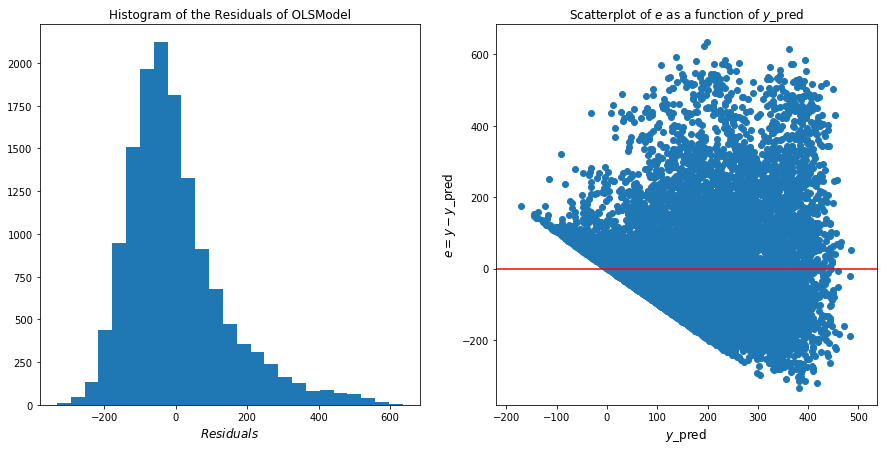

In [31]:
# your code here
fig_rs, ax_rs = plt.subplots(1, 2, figsize = (15,7))

ax_rs[0].hist(OLSModel.resid, bins = 25)
ax_rs[0].set_xlabel(r'$Residuals$', fontsize = 12)
ax_rs[0].set_title('Histogram of the Residuals of OLSModel')

ax_rs[1].scatter(OLSModel.predict(X_train_ca), OLSModel.resid)
ax_rs[1].hlines(y=0, xmin = np.min(OLSModel.predict(X_train_ca))-50, xmax = np.max(OLSModel.predict(X_train_ca))+50, color = 'red')
ax_rs[1].set_xlabel(r'$y$_pred', fontsize = 12)
ax_rs[1].set_ylabel(r'$e = y - y$_pred', fontsize = 12)
ax_rs[1].set_xlim(xmin = np.min(OLSModel.predict(X_train_ca))-50, xmax = np.max(OLSModel.predict(X_train_ca))+50)
ax_rs[1].set_title('Scatterplot of $e$ as a function of $y$_pred')

**Answer:**

*The **histogram** of the residuals is skewed to the right, thus, it is clear that the residuals are not normally distributed. The **scatterplot** to the right shows that the assumptions of constant variance are violated as well since the variance changes with $y$_pred. Also, we can observe that the axis for residuals is almost rotated by a certain angle, which tells us that the linearity assumption is violated as well. Thus, the assumptions of the OLS model are not holding for this data set and we need to explore higher degree terms to fit the non-linearity.*


#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [32]:
# your code here
# pd.DataFrame(np.array(X_train).reshape(-1, X_train.shape[1]), columns = X_train.columns)
X_train_poly = X_train.copy()
X_train_poly['temp2'] = X_train_poly['temp']**2
X_train_poly['hour2'] = X_train_poly['hour']**2
X_train_poly['hum2'] = X_train_poly['hum']**2

X_test_poly = X_test.copy()
X_test_poly['temp2'] = X_test_poly['temp']**2
X_test_poly['hour2'] = X_test_poly['hour']**2
X_test_poly['hum2'] = X_test_poly['hum']**2

OLS_poly = sm.OLS(y_train, sm.add_constant(X_train_poly))
OLSModel_poly = OLS_poly.fit()

print(OLSModel_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     421.8
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        09:39:00   Log-Likelihood:                -87102.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13869   BIC:                         1.745e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -185.2131     14.016    -13.214      0.0

In [33]:
score_test_poly = r2_score(y_test, OLSModel_poly.predict(sm.add_constant(X_test_poly)))
score_train_poly = r2_score(y_train, OLSModel_poly.predict(sm.add_constant(X_train_poly)))

print('R^2 on full training set with polynomial features:%s'%score_train_poly)
print('R^2 on full testing set with polynomial features:%s'%score_test_poly)

R^2 on full training set with polynomial features:0.5009041530600604
R^2 on full testing set with polynomial features:0.49653116472922565


**Answer:**

*The polynomial terms come out to be significant with p-value $< 0.05$ for all of them. For hour and hum have $+ve$ first degree terms but $-ve$ second degree terms. This means that the rate of decrease in ridership increases with increase in hour and hum. For temp both first and second degree terms are $+ve$ which means that the rate of increase in ridership increases with increase in temperature. Notice that our $R^2$ score has gone up by approx. $~0.1$ compared to the previous model without the polynomial terms.* 

*If we have just a slope coeficient, we can interpret the model as one unit of [input] is worth [coef] units of [output], assuming everything else remains the same. However for polynomial terms, the relationship can be more complex. The direction of the regresion line could change depending on the polynomial terms and the signs associated with the coefficients, as we can clearly see in the above model.*



#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

In [34]:
# your code here
X_train_drop = X_train.drop(labels = ['workingday', 'atemp', 'spring', 'summer', 'fall'], axis = 1)

OLS_mc = sm.OLS(y_train, sm.add_constant(X_train_drop))
OLSModel_mc = OLS_mc.fit()
print(OLSModel_mc.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     358.3
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        09:39:02   Log-Likelihood:                -88363.
No. Observations:               13903   AIC:                         1.768e+05
Df Residuals:                   13876   BIC:                         1.770e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.0627      8.541     -2.349      0.0

**Answer:**

*When there is multicollinearity, the model cannot accurately interpret which of the independent variables is casuing the variance in the response. This can lead to wrong coefficients, wrong signs for the coefficients, wrong p-values and so on. Clearly it makes our model less accurate and usefull if we have predictors that are correlated.*

*In the above example, we do see more meaningful estimates as we get lower standard errors in this model for all the coefficients except storm. Also, the coefficients for all the months except June and July now have a $+ve$ sign, which is more realistic.*

<div class='exercise'><b> Question 5: Subset Selection </b> </div>
Perhaps we can automate finding a good set of predictors. This question focuses on forward stepwise selection, where predictors are added to the model one by one.

**5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

<i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

**5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

### Answers

#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

#### We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

#### <i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

In [35]:
# your code here

def forward_selection(X_train, y_train):
    subset = []
    all_cols = list(X_train_poly.columns)
    prev_bic = float('inf')
    curr_bic = 0
    rem = list(X_train_poly.columns)
    while (True):
        bic = []
        i_val = []
        for i in (rem):
            subset.append(i)
            X_newadd = X_train[subset]
            OLS = sm.OLS(y_train, sm.add_constant(X_newadd))
            OLSModel = OLS.fit()
            bic.append(OLSModel.bic)
            i_val.append(i)
            subset.remove(i)
        curr_bic = min(bic)
        ind = bic.index(min(bic))
        add = i_val[ind]
        if prev_bic>curr_bic:
            subset.append(add)
        else: break
        rem = list(set(subset)^set(all_cols))
        prev_bic = curr_bic
            
    return(subset)

In [36]:
# your code here
best_subset = forward_selection(X_train_poly, y_train)
best_subset

['temp',
 'hour',
 'hour2',
 'year',
 'hum2',
 'fall',
 'Jul',
 'Snow',
 'spring',
 'Sept',
 'holiday',
 'Cloudy']

#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**Answer:**
*We see that the forward selection eliminates the variables workingday, atemp and summer. However, spring and Fall are not eliminated.*

*Forward selection chooses just one best variable at a time on to be added to the existing model. And the selection is made by looking at BIC, in our, which looks at the MSE and the number of variables we have added to the model. So unless the multi-collinearity is so significant that it affects the MSE, it might still add correlated variables.*

#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [37]:
# your code here
X_train_best = X_train_poly[best_subset]
OLS_best = sm.OLS(y_train, sm.add_constant(X_train_best))
OLSModel_best = OLS_best.fit()
print(OLSModel_best.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1148.
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        09:39:19   Log-Likelihood:                -87144.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13890   BIC:                         1.744e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -189.1223      5.283    -35.795      0.0

In [38]:
X_test_best = X_test_poly[best_subset]
score_test_best = r2_score(y_test, OLSModel_best.predict(sm.add_constant(X_test_best)))
score_train_best = r2_score(y_train, OLSModel_best.predict(sm.add_constant(X_train_best)))

print('R^2 on best training set with polynomial features:%s'%score_train_best)
print('R^2 on best testing set with polynomial features:%s'%score_test_best)

R^2 on best training set with polynomial features:0.4979274979859656
R^2 on best testing set with polynomial features:0.49431032355580706


**Answer:**

*The $R^2$ scores on the training and testing set for both, the step-wise model and the polynomial model, are nearly equal. That means that the step-wise model does a good job of eliminating variables without affecting model $R^2$ value.*


#  Written Report to the Administrators [20 pts]
<br>

<div class='exercise'> <b> Question 6 </b> </div>

Write a short repost stating some of your findings on how the administrators can increase the bike share system's revenue. You might want to include suggestions such as what model to use to predict ridership, what additional services to provide, or when to give discounts, etc. 
Include your report as a pdf file in canvas. The report should not be longer than one page (300 words) and should include a maximum of 5 figures. 

#### Answers 6




**Summary Report:**

Using the model obtained by forward selection method yeilds us the best balance between accuracy and complexity. Based on that model, we get temperature, hour, humidity and season to be the top predictors. 

We can see these relationships in the figures below. Temperature has a positive effect on the number of riders (Fig 1.1), humidity has a curvilinear (second degree polynomial) relationship (Fig 1.2) and the increase in weather severity decreases the number of riders (Fig 2). Also observe the spikes at peak hours for registered users in Fig 3. These spikes are at office hours, which tells us that a lot of our registered riders use the system to commute to work.

**Recommendations:**

*1. To generate more revenue for the bike share system, it is important to target the supply strategy. On days with good weather or during rush hours, it is important to ensure there are enough bikes loaded at each station. During bad weathers or past midnight, it is a good time to do bike maintenance.*

*2. Consider starting corporate programs and discounts to reach out to working professionals who might want to try out bike share system at a discounted price.*

*3. Consider starting spring/fall programs and discounts to encourage more people to register at a discounted price when the weather is nice.*

*4. It is a good incentive to give out discounts to the registered riders so they can recommend the bike share system with their friends and family.*

*5. It is good incentive to give out discounts to the casual riders to encourage them to register.*

*6. The demand is increasing by 80 riders each year, make sure to add more capacity to adjust for the increase in demand.*



Text(0.5,1,'Fig. 1.2 Humidity vs. Total Riders')

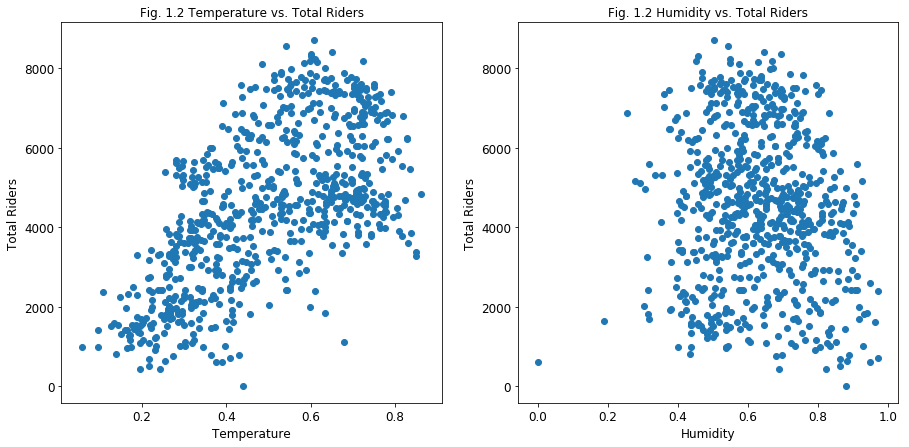

In [39]:
# your code here
fig_sc, ax_sc = plt.subplots(1, 2, figsize=(15,7))
ax_sc[0].scatter(bikes_by_day.temp, bikes_by_day.counts)
ax_sc[0].set_xlabel('Temperature', fontsize=12)
ax_sc[0].set_ylabel('Total Riders', fontsize=12)
ax_sc[0].tick_params(labelsize=12)
ax_sc[0].set_title('Fig. 1.2 Temperature vs. Total Riders', fontsize=12)

ax_sc[1].scatter(bikes_by_day.hum, bikes_by_day.counts)
ax_sc[1].set_xlabel('Humidity', fontsize=12)
ax_sc[1].set_ylabel('Total Riders', fontsize=12)
ax_sc[1].tick_params(labelsize=12)
ax_sc[1].set_title('Fig. 1.2 Humidity vs. Total Riders', fontsize=12)

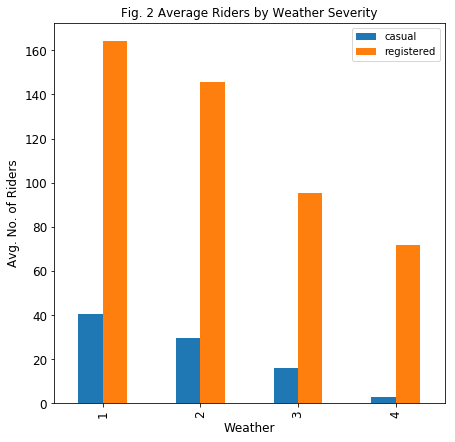

In [40]:
fig_wr, ax_wr = plt.subplots(1, 1, figsize=(7,7))
df_bar_wr.plot.bar(ax = ax_wr, title = 'Fig. 2 Average Riders by Weather Severity')
ax_wr.set_xlabel('Weather', fontsize=12)
ax_wr.set_ylabel('Avg. No. of Riders', fontsize=12)
ax_wr.tick_params(labelsize=12)

Text(0.5,1,'Fig. 3 Average Number of Riders for Each Hour')

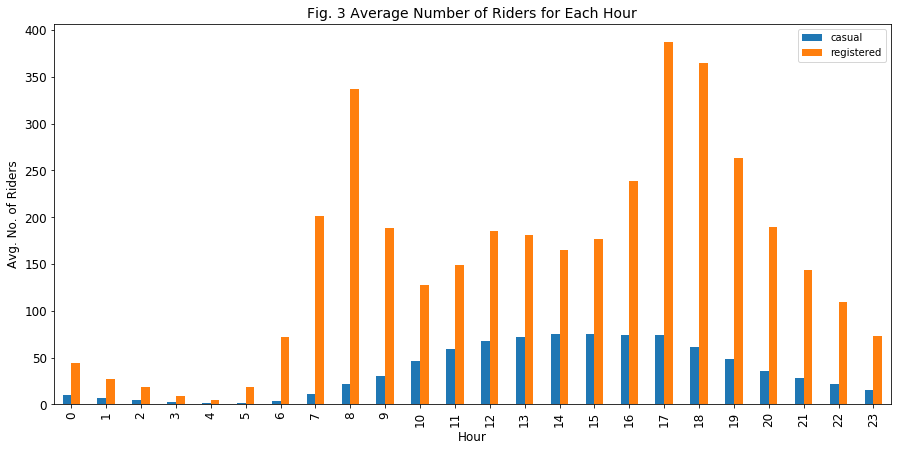

In [41]:
#your code here
bikes_gb_hr = bikes_df.groupby(by = 'hour')
df_bar = bikes_gb_hr[['casual', 'registered']].mean()

df_bar.index

fig_hr, ax_hr = plt.subplots(1, 1, figsize=(15,7))
df_bar.plot.bar(ax = ax_hr)
ax_hr.set_xlabel('Hour', fontsize=12)
ax_hr.set_ylabel('Avg. No. of Riders', fontsize=12)
ax_hr.tick_params(labelsize=12)
ax_hr.set_title('Fig. 3 Average Number of Riders for Each Hour', fontsize=14)